# Latent Dirichlet Allocation

In [1]:
import wikipediaapi
import re
from string import punctuation
import nltk
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Use an api to get articles from wikipedia

In [2]:
pages = [
    "American Civil War",
    "Abraham Lincoln",
    "Slavery in the United States",
    "Slave states and free states",
    "Emancipation Proclamation",
    "Robert E. Lee",
    "Ulysses S. Grant",
    "Conclusion of the American Civil War",
    "Origins of the American Civil War",
    "Issues of the American Civil War"
]

In [3]:
import re

def underscorize(pagename):
    return re.sub(" ", "_", pagename)

https://pypi.org/project/Wikipedia-API/

In [4]:
wiki_wiki = wikipediaapi.Wikipedia(
        language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI
)

In [5]:
page_dict = {}
for page in pages:
    pagename = underscorize(page)
    print(pagename)
    p_wiki = wiki_wiki.page(pagename)
    page_text = p_wiki.text.split("\n")
    page_paras = [para for para in page_text if len(para) > 1]
    page_dict[pagename] = page_paras

American_Civil_War
Abraham_Lincoln
Slavery_in_the_United_States
Slave_states_and_free_states
Emancipation_Proclamation
Robert_E._Lee
Ulysses_S._Grant
Conclusion_of_the_American_Civil_War
Origins_of_the_American_Civil_War
Issues_of_the_American_Civil_War


## Tokenize each paragraph of each article of the articles

We are keeping one big list of all of the tokenized paragraphs, as well as storing the tokenized paragraphs for each article in a dictionary.

In [6]:
def bruces_alpha_only(text, stem_text=False, alpha_only=True, lower_case=True):
    import re
    from nltk import stem  # @UnresolvedImport
    
    def is_contraction(the_text):
        contraction_patterns = re.compile(r"(?i)(.)('ll|'re|'ve|n't|'s|'m|'d)\b")
        return contraction_patterns.search(the_text)

    def return_alpha_only (ltext):
        return [w for w in ltext if (len(w) > 0) and (w.isalpha() or w[0]=='<' or is_contraction(w))]
    
    stemmer = stem.PorterStemmer()
    if lower_case:
        text = text.lower()
    punctuation_class = r"([\.\-\/&\";:\(\)\?\!\]\[\{\}\*#])"
    
    # Separate most punctuation at end of words

    text = re.sub(r"(\w)" + punctuation_class, r'\1 \2 ', text)
    
    # Separate most punctuation at start of words
    text = re.sub(punctuation_class + r"(\w)", r'\1 \2', text)
    
    # Separate punctuation from other punctuation
    text = re.sub(punctuation_class + punctuation_class, r'\1 \2 ', text)
    
    # Put spaces between + and = signs and digits. Also %s that follow a digit, $s that come before a digit
    text = re.sub(r"(\d)([+=%])", r'\1 \2 ', text)
    text = re.sub(r"([\$+=])(\d)", r'\1 \2', text)
    
    # Separate commas if they're followed by space.
    # (E.g., don't separate 2,500)
    text = re.sub(r"(,\s)", r' \1', text)
    
    #when we have two double quotes make it 1.
    #
    text = re.sub("\"\"", "\"", text)

    # Separate leading and trailing single and double quotes .
    text = re.sub(r"(\'\s)", r' \1', text)
    text = re.sub(r"(\s\')", r'\1 ', text)
    text = re.sub(r"(\"\s)", r' \1', text)
    text = re.sub(r"(\s\")", r'\1 ', text)
    text = re.sub(r"(^\")", r'\1 ', text)
    text = re.sub(r"(^\')", r'\1 ', text)
    text = re.sub(r"('\'$)", r' \1', text)
    text = re.sub(r"('\"$)", r' \1', text)

    #Separate parentheses where appropriate
    text = re.sub(r"(\)\s)", r' \1', text)
    text = re.sub(r"(\s\()", r'\1 ', text)

    # Separate periods that come before newline or end of string.
    text = re.sub('\. *(\n|$)', ' . ', text)
    
    # separate single quotes in the middle of words
    # text = re.sub(r"(\w)(\')(\w)", r'\1 \2 \3', text)
    
    # separate out 's at the end of words
    text = re.sub(r"(\w)(\'s)(\s)", r"\1 s ", text)
    split_text = text.split()
    
    if stem_text:
        result = [stemmer.stem(w) for w in split_text]
        split_text = result

    if alpha_only:
        split_text = return_alpha_only(split_text)
    return split_text

In [7]:
tokenized_paras = []
tokenized_page_dict = {}
for name, page in page_dict.items():
    tokenized_page_paras = []
    for para in page:
        tokenized_page_paras.append(bruces_alpha_only(para))
    tokenized_page_dict[name] = tokenized_page_paras
    tokenized_paras += tokenized_page_paras

In [8]:
len(tokenized_paras)

1573

## Remove stopwords as usual

In [9]:
f = open("lists/stop-words_english_1_en.txt")
stop_list = f.read().split("\n")
stop_list += list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’')
stop_list += list("abcdefghijklmnopqrstuvwxyz0123456789")
stop_list = set(stop_list)

In [10]:
docs_no_stop = []
for doc in tokenized_paras:
    new_doc = [w for w in doc if w not in stop_list]
    docs_no_stop.append(new_doc)

## Vectorizing in Gensim

A gensim dictionary maps every token (i.e, word) to a number. It also computes some frequencies for us.

https://radimrehurek.com/gensim/corpora/dictionary.html

In [36]:
gensim_dict = corpora.Dictionary(docs_no_stop) 

In [19]:
gensim_dict.token2id["lincoln"]

20

In [16]:
gensim_dict[20]

'lincoln'

In [20]:
gensim_dict.dfs[20]

237

A gensim dictionary can be used to create a vector from a document.

Gensim does a better job of representing sparse vectors - vectors with lots of zeros in them.

In [ ]:
gensim_dict.doc2bow(docs_no_stop[0])

### Convert all of the documents to bags of words, in the gensim manner

In [37]:
cw_bows = [gensim_dict.doc2bow(doc) for doc in docs_no_stop] 

## Do the LDA

In [24]:
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.CRITICAL)

In [25]:
# logging.getLogger().setLevel(logging.INFO)
logging.getLogger().setLevel(logging.CRITICAL)

In [26]:
lda_m1 = models.LdaModel(cw_bows, 
                         id2word=gensim_dict, 
                         num_topics=8,
                          passes=10,
                          update_every=0,
                          chunksize=2000,
                          iterations=100,
                          gamma_threshold=.001,
                          decay=.5,
                          offset=1,
                          random_state=1,
                          alpha="auto")

## Examine the results

In [27]:
lda_m1.print_topics()

[(0,
  '0.027*"states" + 0.021*"slavery" + 0.014*"slave" + 0.014*"free" + 0.012*"slaves" + 0.010*"state" + 0.010*"united" + 0.010*"war" + 0.009*"union" + 0.008*"south"'),
 (1,
  '0.026*"grant" + 0.022*"war" + 0.016*"lee" + 0.015*"civil" + 0.007*"army" + 0.007*"union" + 0.006*"american" + 0.006*"south" + 0.006*"confederate" + 0.005*"slavery"'),
 (2,
  '0.023*"lincoln" + 0.016*"grant" + 0.007*"army" + 0.007*"lee" + 0.005*"general" + 0.005*"war" + 0.005*"abraham" + 0.005*"isbn" + 0.004*"family" + 0.004*"robert"'),
 (3,
  '0.018*"lincoln" + 0.015*"grant" + 0.011*"union" + 0.010*"states" + 0.010*"slavery" + 0.008*"party" + 0.007*"republican" + 0.005*"lee" + 0.005*"army" + 0.005*"slave"'),
 (4,
  '0.028*"lee" + 0.010*"war" + 0.008*"confederate" + 0.006*"american" + 0.006*"union" + 0.005*"virginia" + 0.005*"general" + 0.005*"states" + 0.004*"lincoln" + 0.004*"army"'),
 (5,
  '0.016*"slaves" + 0.014*"slavery" + 0.011*"slave" + 0.010*"war" + 0.009*"south" + 0.006*"southern" + 0.005*"white" + 0.

In [28]:
def top_words_from_topic(lda_model, gdict, n, to_print=10, min_oc=10):
    result = [["word", "weight", "df"]]
    topic_words = lda_model.show_topic(n, 100)
    cnt = 0
    i = 0 
    while cnt < to_print:
        res = topic_words[i]
        w = res[0]
        df = gdict.dfs[gdict.token2id[w]]
        if df > min_oc:
            result.append([res[0], round(res[1], 3), df])
            cnt += 1
        i += 1
    return result

def top_words_from_topics(lda_model, gdict, to_print=10, min_oc=10):
    result = []
    for n in range(lda_model.num_topics):
        result.append(top_words_from_topic(lda_model, gdict, n, to_print, min_oc))
    return result
        
class ListTable(list):
    def _repr_html_(self):
        html = ["<table style= 'border: 1px solid black; display:inline-block'>"]
        for row in self:
            html.append("<tr>")
            for col in row:
                html.append("<td align='left' style='border: .5px solid gray;'>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
import numpy
class MultiTable(list):
    def _repr_html_(self):
        html = []
        for l in self:
            html.append("<table style= 'border: 1px solid black; display:inline-block; margin-right: 10px;'>")
            for row in l:
                html.append("<tr>")
                for col in row:
                    if isinstance(col, numpy.float32):
                        col = str(round(col, 3))
                    html.append("<td align='left' style='border: .5px solid gray;'>{0}</td>".format(col))
                html.append("</tr>")
            html.append("</table>")
        return ''.join(html)

In [29]:
MultiTable(top_words_from_topics(lda_m1, gensim_dict, min_oc=1))

word,weight,df
states,0.027,321
slavery,0.021,375
slave,0.014,223
free,0.014,157
slaves,0.012,219
state,0.01,153
united,0.01,160
war,0.01,441
union,0.009,254
south,0.008,257


In [30]:
gensim_dict.filter_extremes(no_below=5, no_above=0.25) 
cw_bows = [gensim_dict.doc2bow(doc) for doc in docs_no_stop] 

In [45]:
lda_m2 = models.LdaModel(cw_bows, 
                         id2word=gensim_dict, 
                         num_topics=8,
                          passes=50,
                          update_every=0,
                          chunksize=2000,
                          iterations=100,
                          gamma_threshold=.001,
                          decay=.5,
                          offset=1,
                          random_state=1,
                          alpha="auto")

In [46]:
MultiTable(top_words_from_topics(lda_m2, gensim_dict, min_oc=1))

word,weight,df
states,0.035,321
slavery,0.029,375
slave,0.018,223
slaves,0.016,219
free,0.014,157
state,0.013,153
united,0.011,160
south,0.011,257
union,0.009,254
war,0.009,441


In [47]:
vis_data = pyLDAvis.gensim.prepare(lda_m2, cw_bows, gensim_dict)
pyLDAvis.display(vis_data)

In [58]:
import copy
gdict_filtered = copy.deepcopy(gensim_dict)
gdict_filtered.filter_extremes(no_below=30, no_above=0.5)
cw_bows_filtered = [gdict_filtered.doc2bow(doc) for doc in docs_no_stop] 
tfidfmodel = models.TfidfModel(cw_bows_filtered)
tfidfvecs = tfidfmodel[cw_bows]

In [59]:
lda_m3 = models.LdaModel(tfidfvecs, 
                         id2word=gdict_filtered, 
                         num_topics=8,
                          passes=25,
                          update_every=0,
                          chunksize=2000,
                          iterations=100,
                          gamma_threshold=.001,
                          decay=.5,
                          offset=1,
                          random_state=1,
                          alpha="auto")

In [63]:
vis_data = pyLDAvis.gensim.prepare(lda_m3, tfidfvecs, gdict_filtered)
pyLDAvis.display(vis_data)

In [64]:
MultiTable(top_words_from_topics(lda_m3, gdict_filtered, min_oc=1))

word,weight,df
missouri,0.255,61
control,0.106,63
state,0.093,153
government,0.063,104
general,0.052,133
northern,0.046,123
historian,0.043,62
days,0.027,39
southern,0.019,177
fought,0.012,35


## Examine the topics in individual documents

### First gather all of the info we'll need

* each tokenized page
* bow for each page
* topics for each overall page

In [65]:
pagenames = list(tokenized_page_dict.keys())
tokenized_pages = {}
article_bows = {}
article_topics = {}
for pagename in pagenames:
    tokenized_page_rows = tokenized_page_dict[pagename]
    flat_list = []
    for r in tokenized_page_rows:
        for item in r:
            flat_list.append(item)
    tokenized_pages[pagename] = flat_list
    article_bows[pagename] = gensim_dict.doc2bow(flat_list)
    article_topics[pagename] = lda_m1[article_bows[pagename]]

### Put the topics for the pages in a matrix

In [69]:
import numpy as np
tarray = np.zeros([len(pagenames), lda_m1.num_topics])
for n, pagename in enumerate(pagenames):
    art_topics = article_topics[pagename]
    for t in art_topics:
        tarray[n, t[0]] = t[1]
tarray.shape

(10, 8)

### Display a heatmap for the matrix

In [67]:
topic_labels = []
for topic in top_words_from_topics(lda_m2, gensim_dict, min_oc=1):
    label = topic[1][0] + "-" + topic[2][0]
    topic_labels.append(label)
topic_labels

['states-slavery',
 'grant-war',
 'lincoln-grant',
 'lincoln-grant',
 'lee-war',
 'slaves-slavery',
 'lee-confederate',
 'lincoln-slavery']

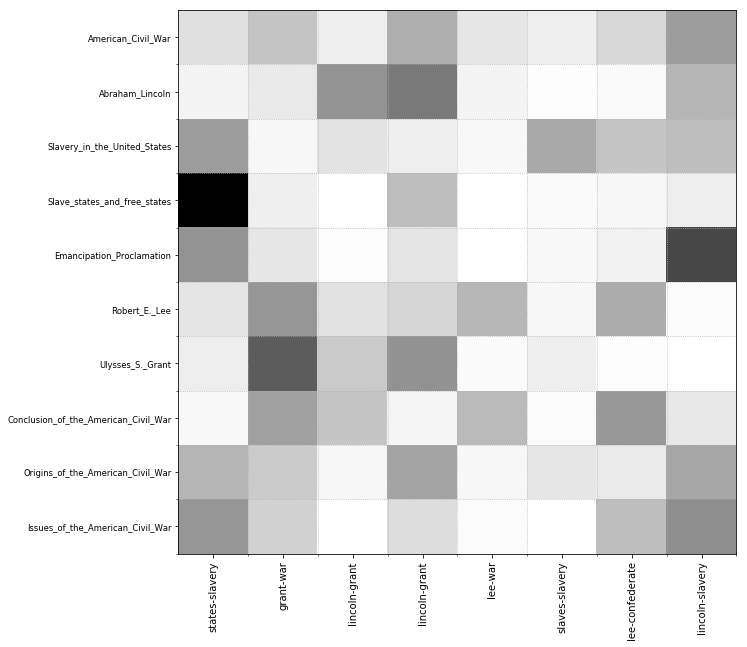

In [70]:
import matplotlib
import matplotlib.cm as cm
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
dialogs = []
(nrows, ncols) = tarray.shape
cax = ax.imshow(tarray, cmap=cm.gist_yarg, aspect="auto", interpolation='nearest')

ind = np.arange(ncols)
ax.set_xticks(ind, minor=False)
ax.set_xticks(ind + .5, minor=True)
ax.get_xaxis().set_ticklabels(topic_labels, size="medium", rotation="vertical")

ind = np.arange(nrows)

ax.set_yticks(ind, minor=False)
ax.set_yticks(ind + .5, minor=True)
ax.get_yaxis().set_ticklabels(pagenames, size="small", rotation="horizontal")

ax.grid(True, which='minor', linestyle=':')

fig.set_facecolor("white")

### Look at the topics in an individual article

In [71]:
# tokenized_page = tokenized_page_dict["American_Civil_War"]
tokenized_page = tokenized_page_dict["Emancipation_Proclamation"]
article_bows = [gensim_dict.doc2bow(para) for para in tokenized_page]
article_topics = lda_m1[article_bows]

In [95]:
import numpy as np
tarray = np.zeros([lda_m1.num_topics, len(article_topics)])
for n, para in enumerate(article_topics):
    for t in para:
        tarray[t[0], n] = t[1]
tarray.shape

(8, 247)

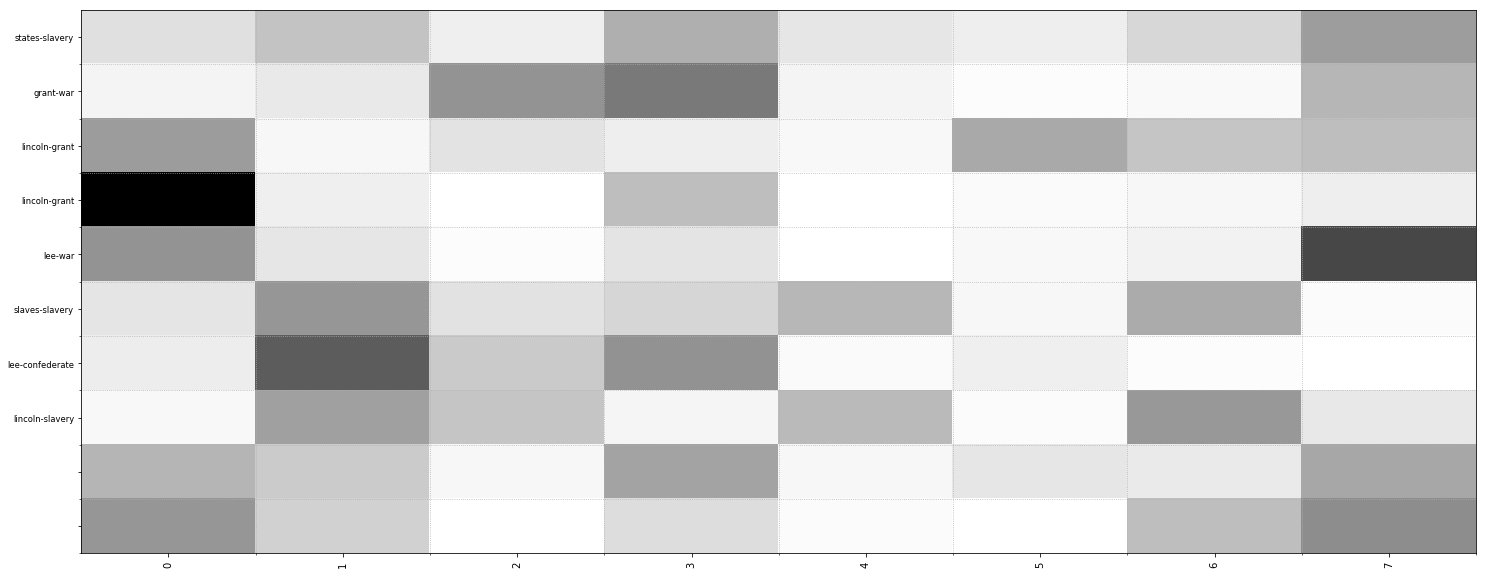

In [72]:
import matplotlib
import matplotlib.cm as cm
fig = matplotlib.pyplot.figure(figsize=(25, 10))
ax = fig.add_subplot(111)
dialogs = []
nrows, ncols = tarray.shape
cax = ax.imshow(tarray, cmap=cm.gist_yarg, aspect="auto", interpolation='nearest')
indices = np.arange(ncols)
ax.set_xticks(indices, minor=False)
ax.set_xticks(indices + .5, minor=True)
ax.get_xaxis().set_ticklabels(list(range(ncols)), size="medium", rotation="vertical")
indices = np.arange(nrows)
ax.set_yticks(indices, minor=False)
ax.set_yticks(indices + .5, minor=True)
ax.get_yaxis().set_ticklabels(topic_labels, size="small", rotation="horizontal")

ax.grid(True, which='minor', linestyle=':')

fig.set_facecolor("white")